# Data preprocessing

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import plotly.express as px
import warnings

#Turing off the warnings
warnings.filterwarnings('ignore')

##Load data
data_prague = pd.read_csv('listings.csv')
data_prague
 
##Exploratory Data Analysis
data_prague.head
data_prague.describe

print("Rows count: ", data_prague.shape[0])
print("Columns count: ", data_prague.shape[1])
rows_count_1 =  data_prague.shape[0]
columns_count_1 = data_prague.shape[1]

Rows count:  9388
Columns count:  75


Original dataset contains 74 variables and 9388 observations. 

We can also see number of observation for each variable and type. 

In [29]:
##Data preprocessing
data_prague.info()
 
### Show the number of NA variables in dataset
isna = data_prague.isna().sum()
isnadf = pd.DataFrame({"isna": isna})
isnadf
 
######## Treating of features with all values being NA
#Remove the column which has all values as NaN - in total 6 columns.
data_prague.dropna(axis = 1, how = 'all', inplace = True)
data_prague.shape
columns_count_2 = data_prague.shape[1]
print("Number of removed columns: ", (columns_count_1 - columns_count_2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            9388 non-null   int64  
 1   listing_url                                   9388 non-null   object 
 2   scrape_id                                     9388 non-null   int64  
 3   last_scraped                                  9388 non-null   object 
 4   source                                        9388 non-null   object 
 5   name                                          9388 non-null   object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         4936 non-null   object 
 8   picture_url                                   9388 non-null   object 
 9   host_id                                       9388 non-null   i

Here we want to determine if we need to use all the features regarding reviews -
whether we want to keep reviews of specific categories. For that purpose we used 
correlation matrix to determine correlation within variables. 

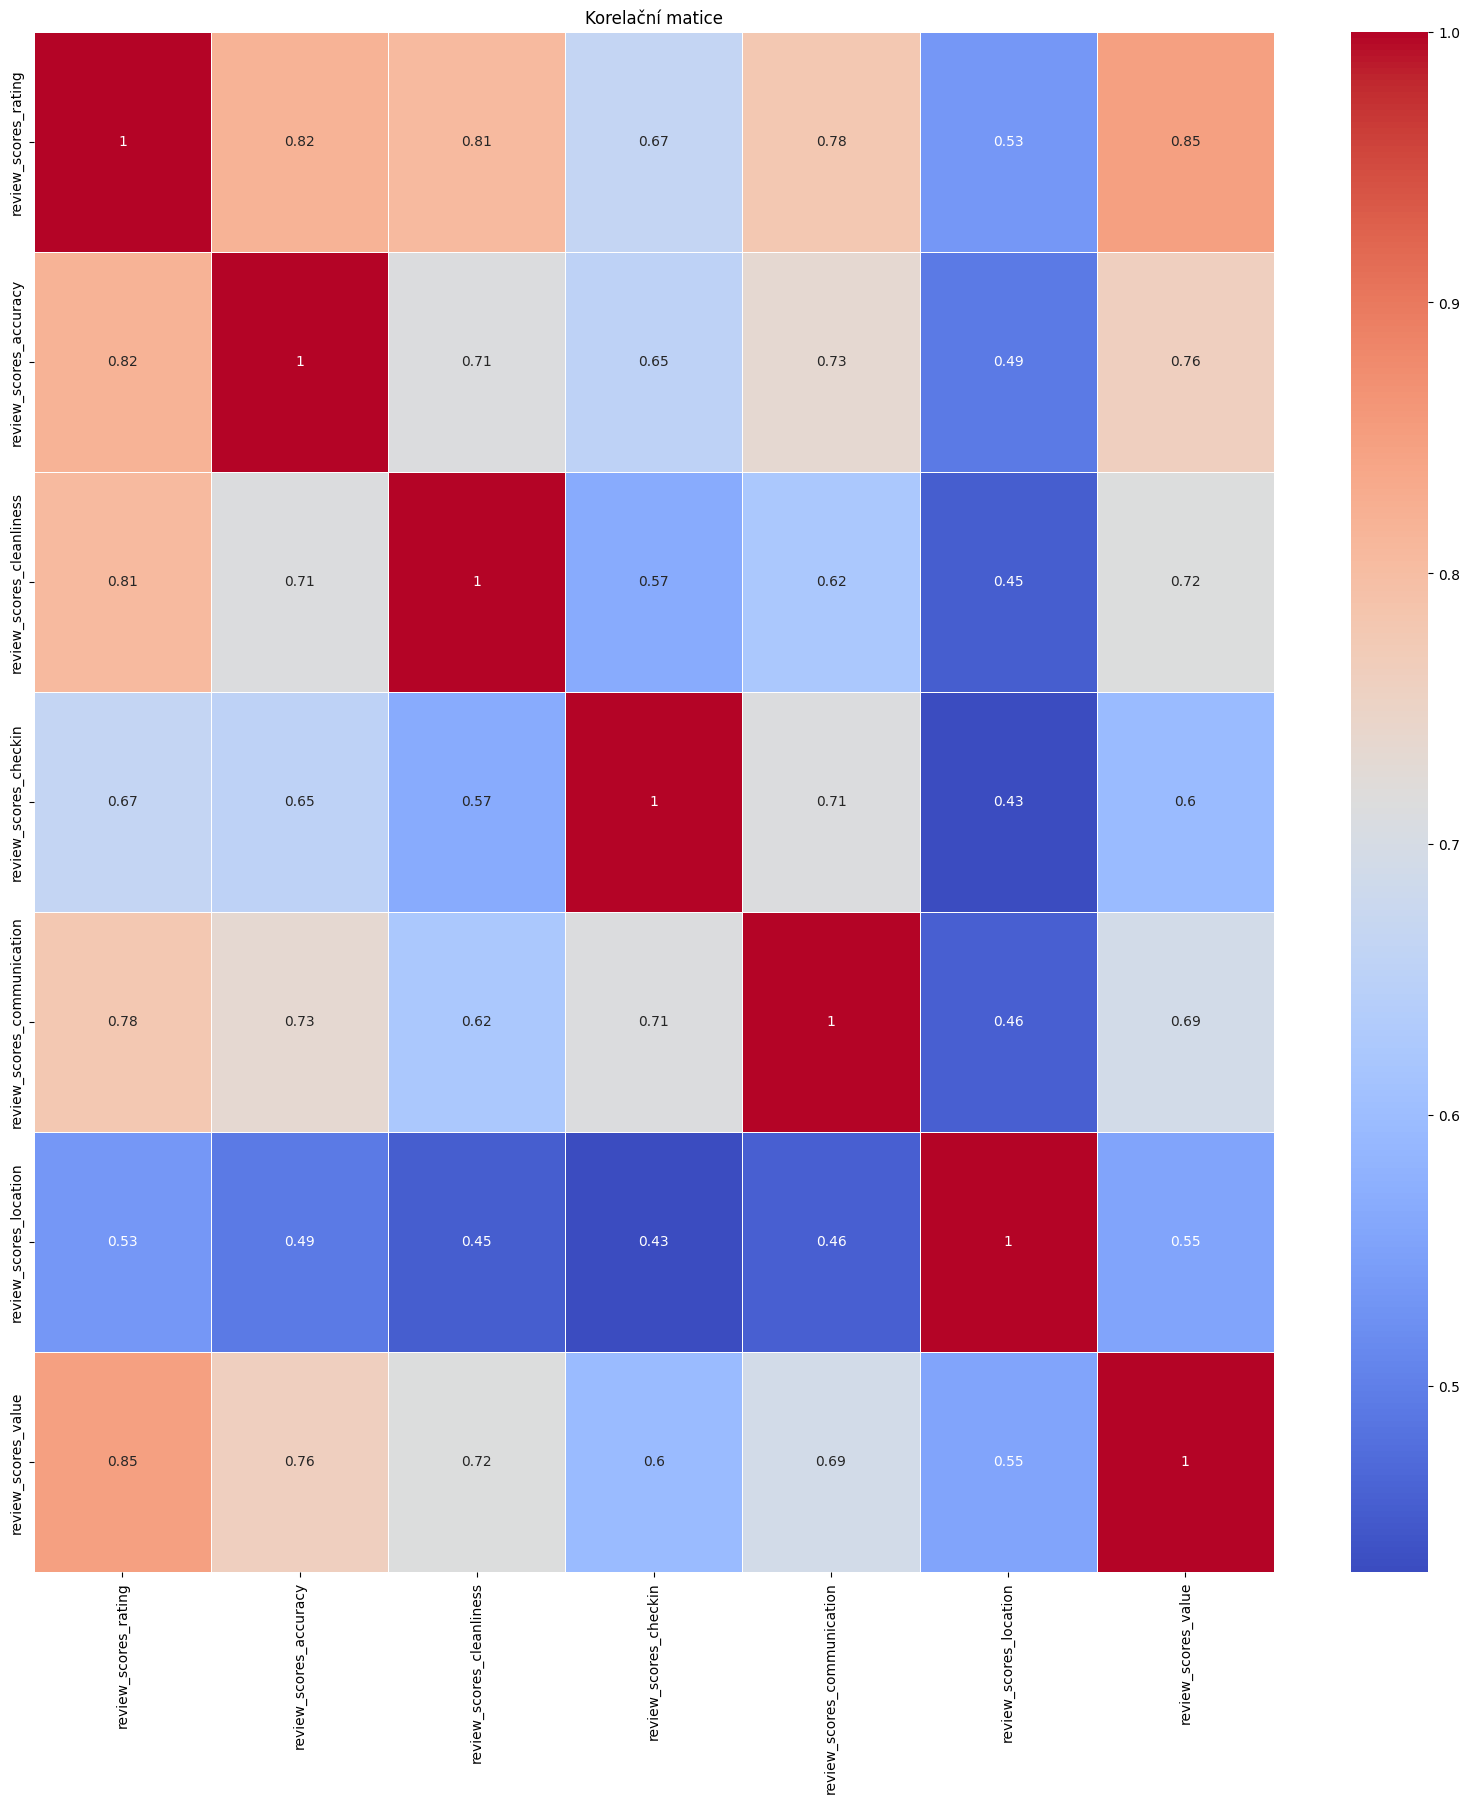

In [30]:
correlation_matrix = data_prague[['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].corr()

#visualization of the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Korelační matice')
plt.show()

We decided to omit most of the review variables and leave only the review_scores_rating - based of the correlation matrix. 

In [31]:
#Drop certain variables that are not important for models.

columns_to_drop = ['listing_url',
                  'scrape_id',
                  'last_scraped',
                  'source',
                  'host_url',
                  'host_name',
                  'host_thumbnail_url',
                  'host_picture_url',
                  'host_listings_count',
                  'host_total_listings_count',
                  'host_verifications',
                  'neighbourhood',
                  'property_type',
                  'amenities',
                  'minimum_minimum_nights',
                  'maximum_minimum_nights',
                  'minimum_maximum_nights',
                  'maximum_maximum_nights',
                  'minimum_nights_avg_ntm',
                  'maximum_nights_avg_ntm',
                  'availability_30',
                  'availability_60',
                  'availability_365',
                  'calendar_last_scraped',
                  'number_of_reviews',
                  'number_of_reviews_ltm',
                  'number_of_reviews_l30d',
                  'first_review',
                  'last_review',
                  'calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms',
                  'calculated_host_listings_count_shared_rooms',
                  'review_scores_accuracy',
                  'review_scores_cleanliness',
                  'review_scores_checkin',
                  'review_scores_communication',
                  'review_scores_location',
                  'review_scores_value',
                  'host_neighbourhood']
 
data_prague.drop(columns_to_drop, axis=1, inplace=True)
 
data_prague.info()
data_prague.describe


#Deleted observation with zero values of price. 
data_prague_price = data_prague.dropna(subset=['price'])
isna_price = data_prague_price.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              9388 non-null   int64  
 1   name                            9388 non-null   object 
 2   neighborhood_overview           4936 non-null   object 
 3   picture_url                     9388 non-null   object 
 4   host_id                         9388 non-null   int64  
 5   host_since                      9388 non-null   object 
 6   host_location                   7197 non-null   object 
 7   host_about                      5407 non-null   object 
 8   host_response_time              8207 non-null   object 
 9   host_response_rate              8207 non-null   object 
 10  host_acceptance_rate            8682 non-null   object 
 11  host_is_superhost               9355 non-null   object 
 12  host_has_profile_pic            93

Editting variables

In [32]:
#variable edit - neighborhood_overview create dummy variable if empty zero, text 1
data_prague_price['neighborhood_overview'] = data_prague_price['neighborhood_overview'].apply(lambda x: 0 if pd.isna(x) else 1)
data_prague_price['neighborhood_overview'].unique() #check
 
#variable edit - neighborhood_overview create dummy variable if empty zero, text 1
data_prague_price['host_about'] = data_prague_price['host_about'].apply(lambda x: 0 if pd.isna(x) else 1)
data_prague_price['host_about'].unique() #check
 
#variable edit - host_location create dummy variable if empty zero, text 1
data_prague_price['host_location'] = data_prague_price['host_location'].apply(lambda x: 1 if pd.notna(x) and 'Czechia' in x else 0)
data_prague_price['host_location'].unique() #check
data_prague_price['host_location'].sum() #check

#variable edit - creating dummy from room type
# reference category is entire home
df_dummy=pd.get_dummies(data = data_prague_price["room_type"], drop_first = True)
df_dummy
data_prague_price = pd.concat([data_prague_price, df_dummy], axis=1)
data_prague_price.dtypes

id                                  int64
name                               object
neighborhood_overview               int64
picture_url                        object
host_id                             int64
host_since                         object
host_location                       int64
host_about                          int64
host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_has_profile_pic               object
host_identity_verified             object
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
room_type                          object
accommodates                        int64
bathrooms_text                     object
beds                              float64
price                              object
minimum_nights                      int64
maximum_nights                    

lets take a look at variable host_since

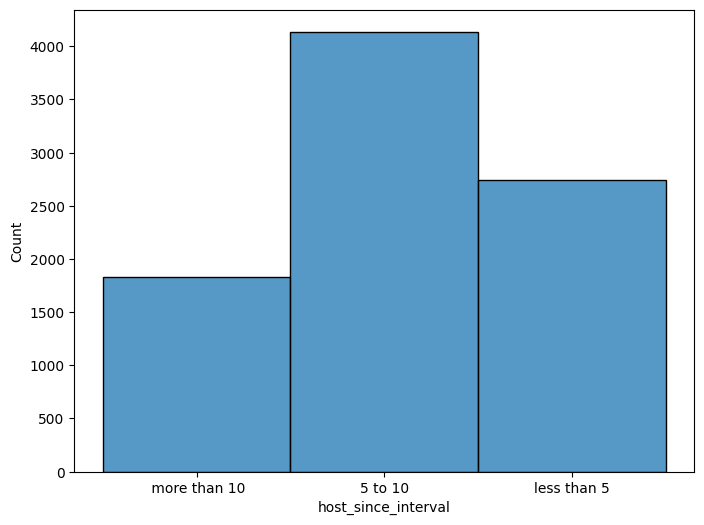

In [33]:
data_prague_price['host_since'] = pd.to_datetime(data_prague_price['host_since'])

date_range = pd.date_range(start=min(data_prague_price['host_since']), end=max(data_prague_price['host_since']), freq='D')
data_prague_price['host_since_interval'] = pd.cut(data_prague_price['host_since'], bins=3, labels=[' more than 10', '5 to 10', 'less than 5'], right=True)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(data_prague_price["host_since_interval"])
plt.show()

# decided to make categories 
# The reference category is more than 10 years on airbnb 
df_dummy = pd.get_dummies(data=data_prague_price["host_since_interval"], drop_first=True)
df_dummy
data_prague_price = pd.concat([data_prague_price, df_dummy], axis=1)
data_prague_price.dtypes


#variable edit - price to float type
data_prague_price['price'] = data_prague_price['price'].str.replace('$','').str.replace(',','')
data_prague_price['price'] = data_prague_price['price'].astype(float)
data_prague_price.dtypes

# Converting variables with % to numbers
data_prague_price['host_acceptance_rate'] = data_prague_price['host_acceptance_rate'].str.rstrip('%').apply(pd.to_numeric, errors='ignore')
data_prague_price['host_response_rate'] = data_prague_price['host_response_rate'].str.rstrip('%').apply(pd.to_numeric, errors='ignore')


#Using the logarithm of prices helps normalize skewed distributions, 
#making data more symmetric and easier to interpret statistically. 
data_prague_price['Lprice'] = np.log(data_prague_price['price'])
 
data_prague_price['bathrooms_cislo'] = data_prague_price['bathrooms_text']
 
data_prague_price['bathrooms_cislo'] = data_prague_price['bathrooms_cislo'].str.replace('Half-bath','0.5').str.replace('Shared half-bath','0.5').str.replace('Private half-bath','0.5')
data_prague_price['bathrooms_cislo'] = data_prague_price['bathrooms_cislo'].str.extract(r'(\d+\.?\d*)').astype(float)#nechá pouze čísla

data_prague_price['bathrooms_text'] = data_prague_price['bathrooms_text'].apply(lambda x: re.sub(r'\d', '', str(x)))
data_prague_price['bathrooms_text'] = data_prague_price['bathrooms_text'].str.replace('.','')



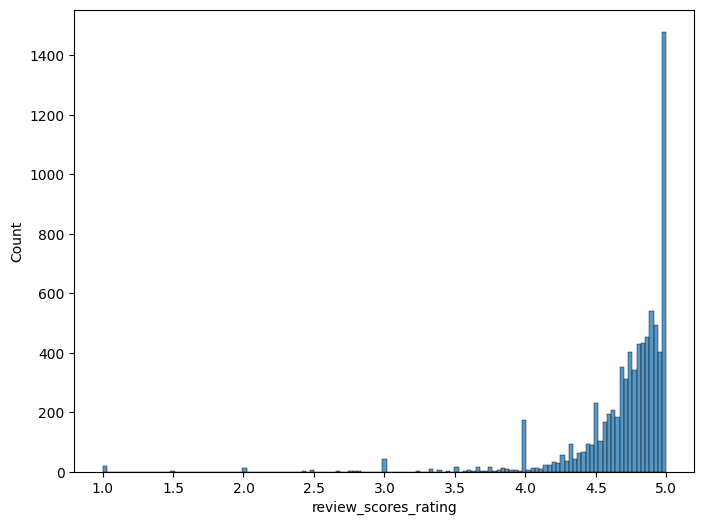

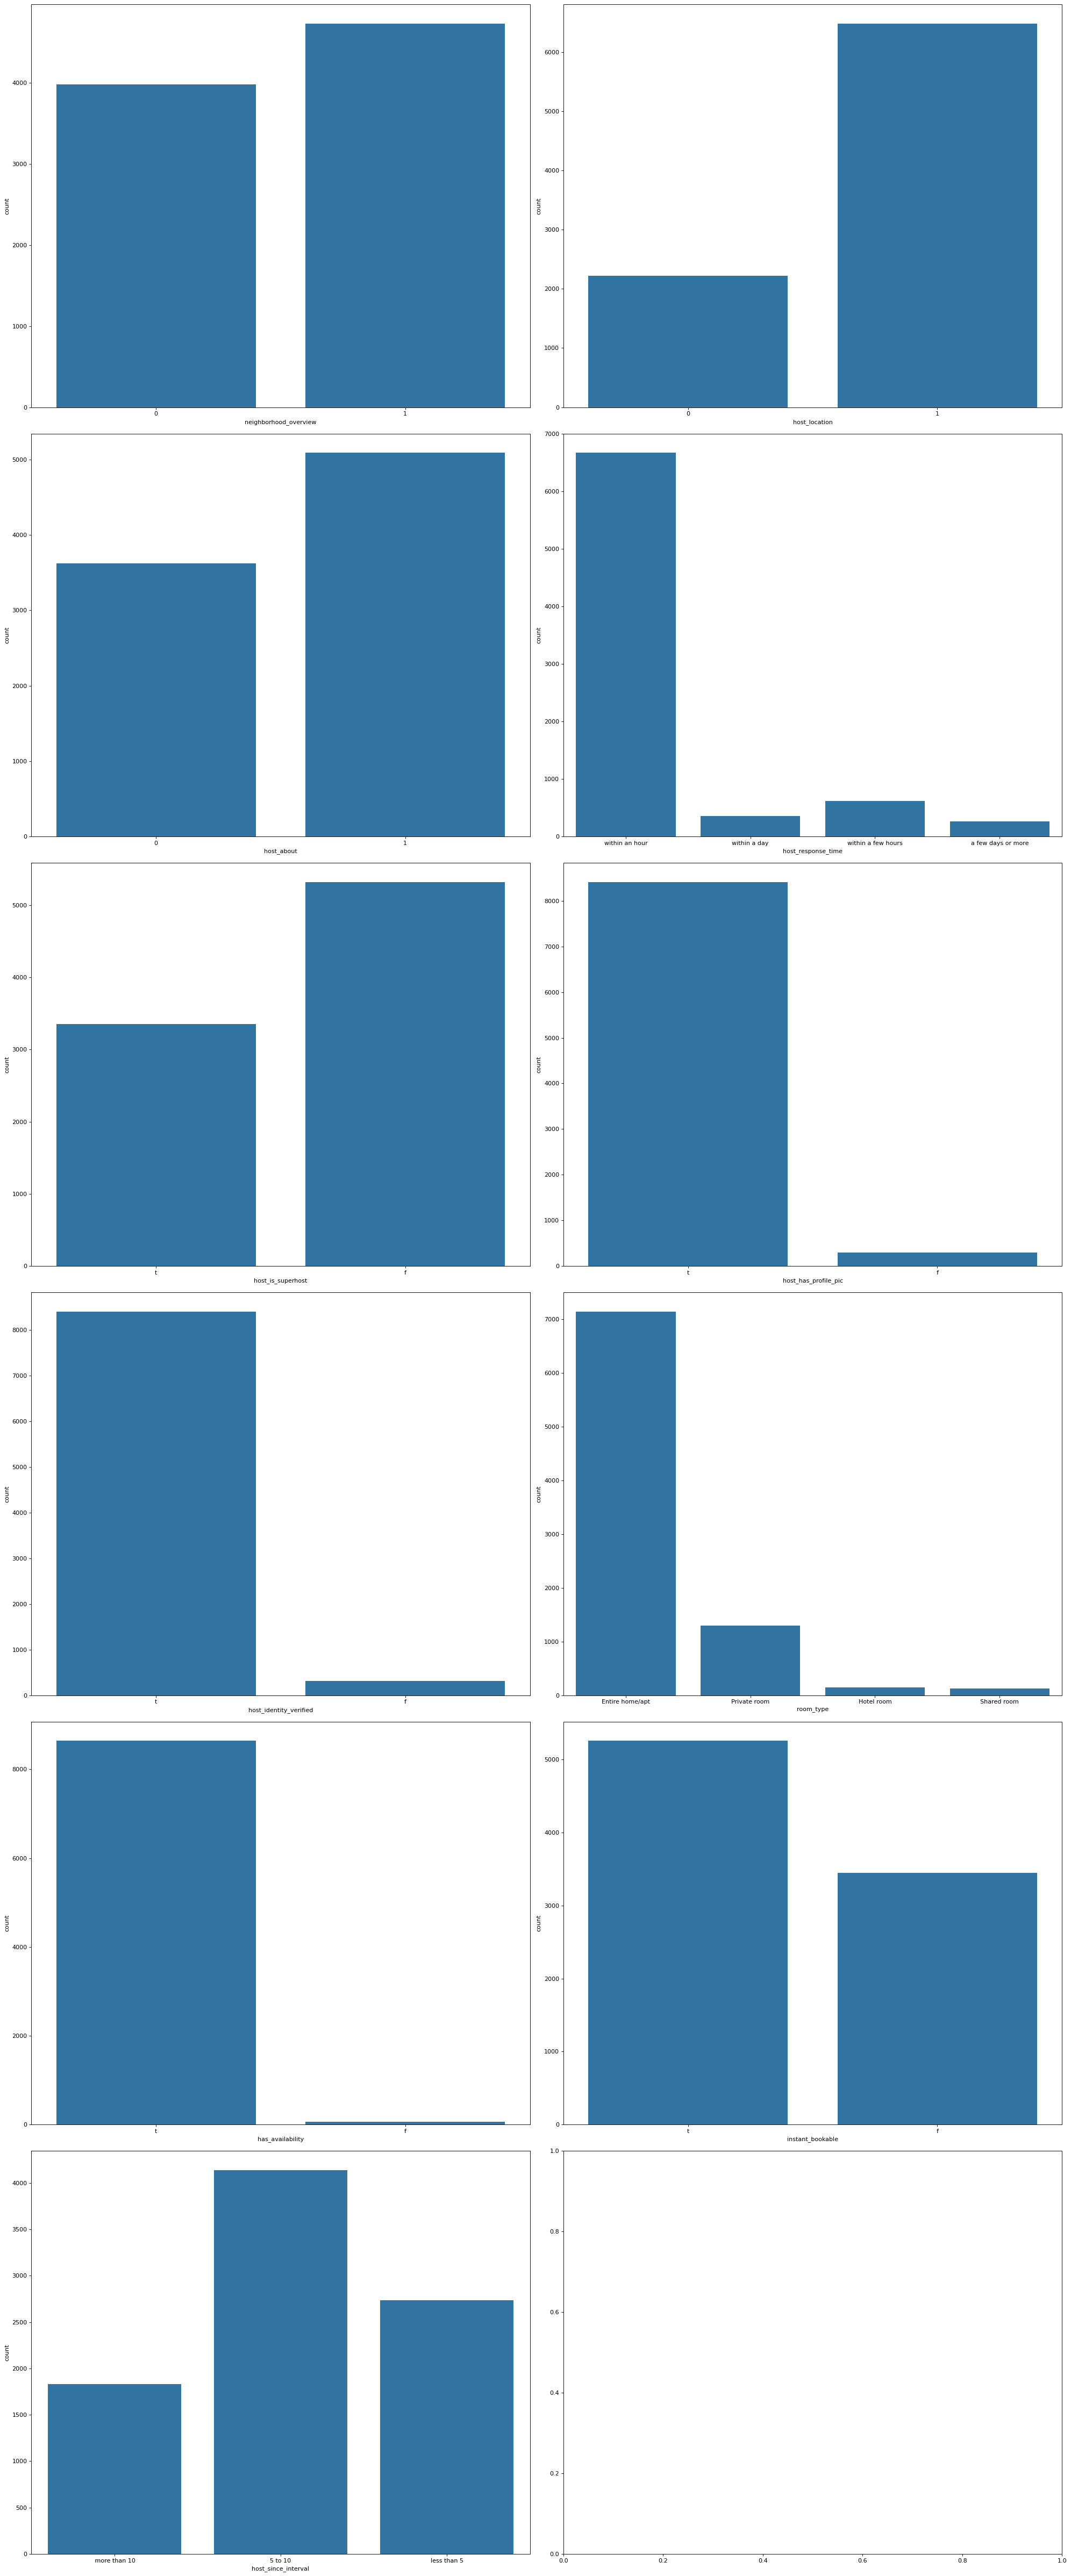

In [34]:
# Figuring number of unique values - just to ensure categories within our variables. 
unique_values_count = data_prague_price.nunique()

# Review_scores_rating graph
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(data_prague_price["review_scores_rating"])
plt.show()

# Column graphs use to visualize categorical variables
fig, axs = plt.subplots(6, 2, figsize=(25, 60), dpi=80)

sns.countplot(data=data_prague_price, x="neighborhood_overview", ax=axs[0, 0])
sns.countplot(data=data_prague_price, x="host_location", ax=axs[0, 1])
sns.countplot(data=data_prague_price, x="host_about", ax=axs[1, 0])
sns.countplot(data=data_prague_price, x="host_response_time", ax=axs[1, 1])
sns.countplot(data=data_prague_price, x="host_is_superhost", ax=axs[2, 0])
sns.countplot(data=data_prague_price, x="host_has_profile_pic", ax=axs[2, 1])
sns.countplot(data=data_prague_price, x="host_identity_verified", ax=axs[3, 0])
sns.countplot(data=data_prague_price, x="room_type", ax=axs[3, 1])
sns.countplot(data=data_prague_price, x="has_availability", ax=axs[4, 0])
sns.countplot(data=data_prague_price, x="instant_bookable", ax=axs[4, 1])
sns.countplot(data=data_prague_price, x="host_since_interval", ax=axs[5, 0])

plt.tight_layout()
plt.show()

#will be described after all the necessary changes 

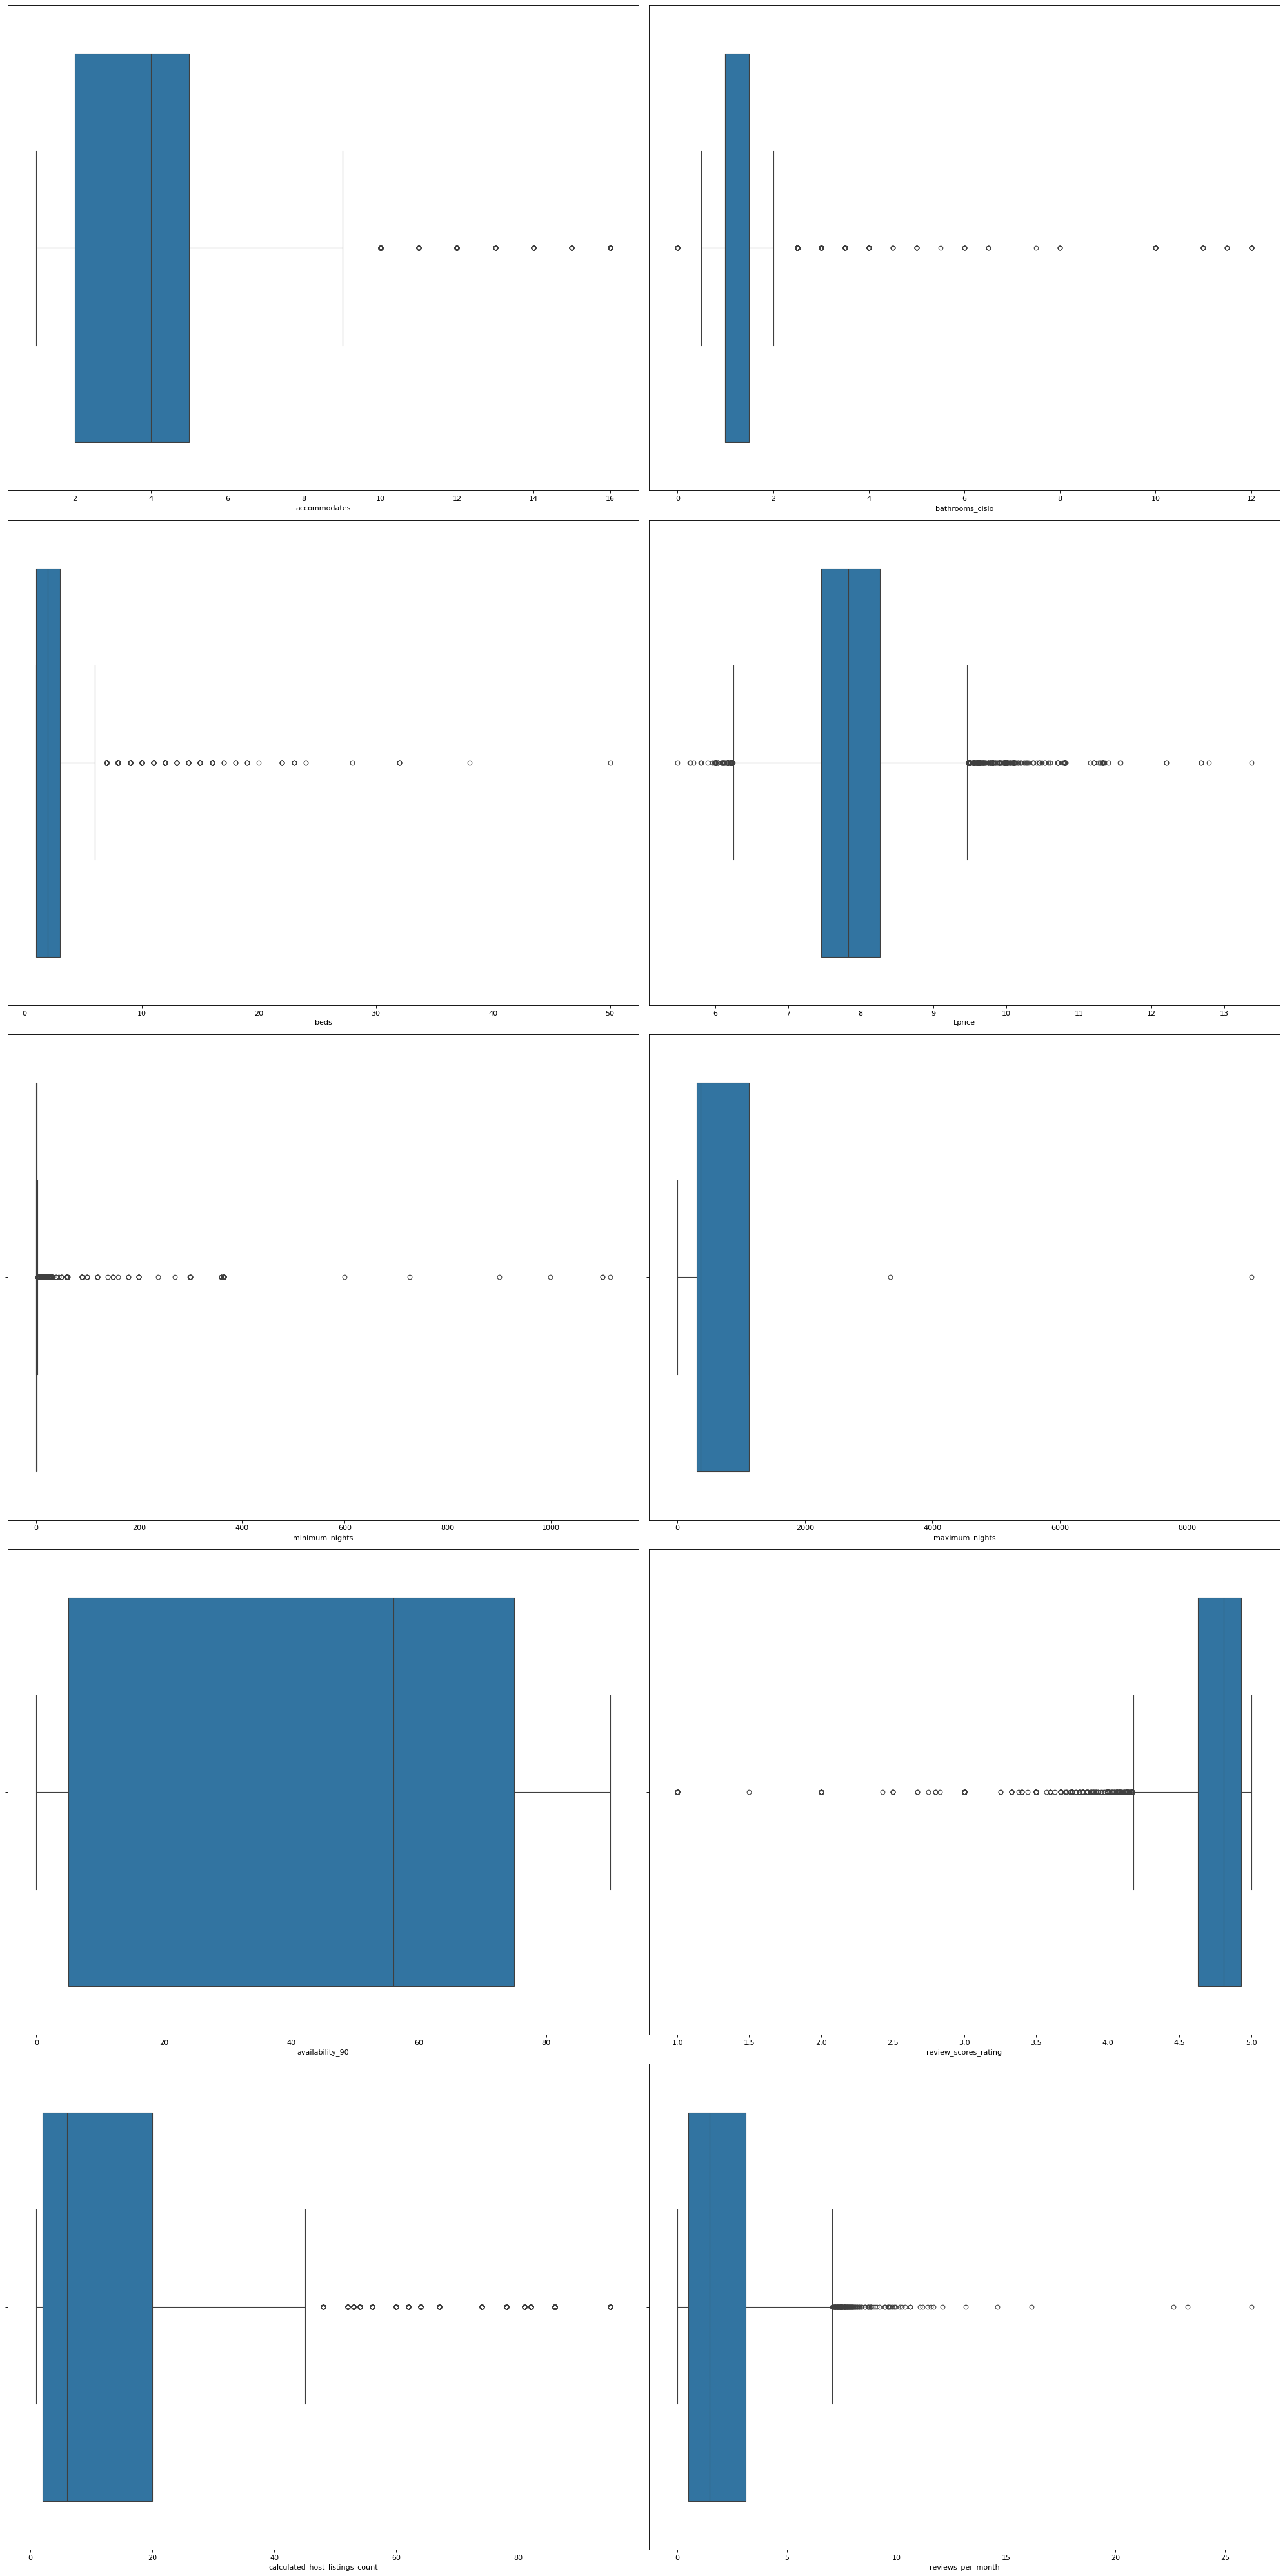

In [35]:
# Boxplots use to visualize numerical variables 
fig, axs = plt.subplots(5, 2, figsize=(25, 50), dpi=80)

sns.boxplot(data=data_prague_price, x="accommodates", ax=axs[0, 0])
sns.boxplot(data=data_prague_price, x="bathrooms_cislo", ax=axs[0, 1])
sns.boxplot(data=data_prague_price, x="beds", ax=axs[1, 0])
sns.boxplot(data=data_prague_price, x="Lprice", ax=axs[1, 1])
sns.boxplot(data=data_prague_price, x="minimum_nights", ax=axs[2, 0])
sns.boxplot(data=data_prague_price, x="maximum_nights", ax=axs[2, 1])
sns.boxplot(data=data_prague_price, x="availability_90", ax=axs[3, 0])
sns.boxplot(data=data_prague_price, x="review_scores_rating", ax=axs[3, 1])
sns.boxplot(data=data_prague_price, x="calculated_host_listings_count", ax=axs[4, 0])
sns.boxplot(data=data_prague_price, x="reviews_per_month", ax=axs[4, 1])

plt.tight_layout()
plt.show()

#will be described after all the necessary changes 


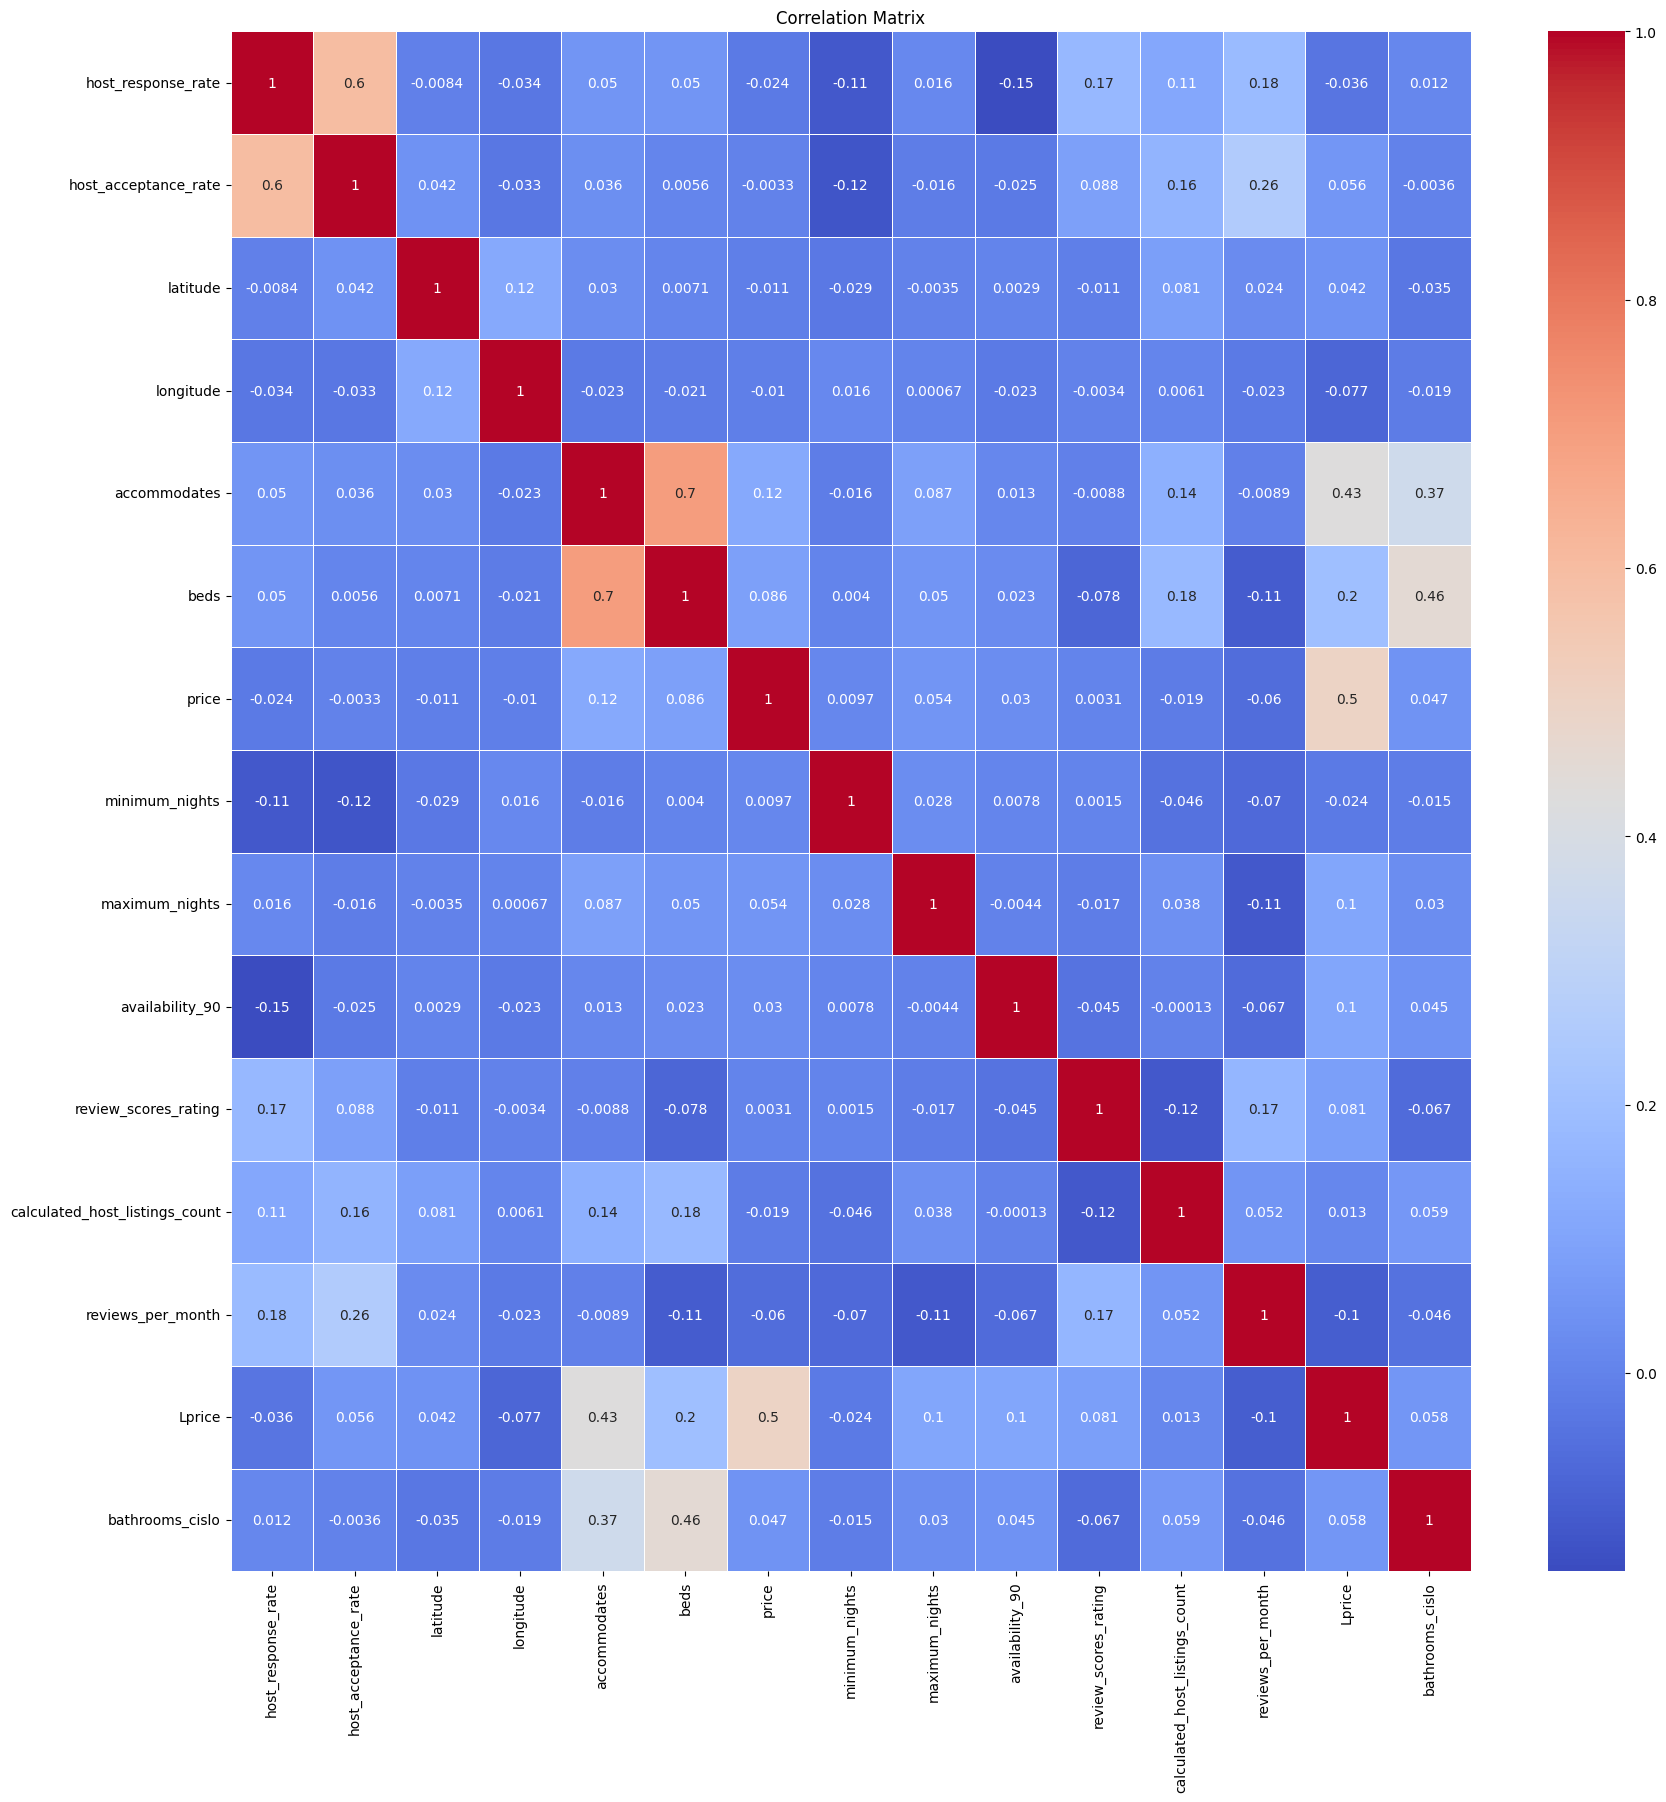

In [36]:
#Summary statistics
summary_stat = data_prague_price.describe(include='all')
summary_stat.transpose

# Dealing with missing values and more categorical variables. 
# Number of unique values
unique_values_count = data_prague_price.nunique()
# Number of missing values
isna_price = data_prague_price.isna().sum()
# Creating DataFrame
summary_df = pd.DataFrame({
    'Unique_Values_Count': unique_values_count,
    'Isna_Count': isna_price
})

data_prague_price = pd.get_dummies(data_prague_price, columns=["host_response_time"], drop_first=True)
data_prague_price = pd.get_dummies(data_prague_price, columns=["neighborhood_overview",
                                                               "host_location",
                                                               "host_about",
                                                               "host_is_superhost",
                                                               "host_has_profile_pic",
                                                               "host_identity_verified",
                                                               "has_availability",
                                                               "instant_bookable"], drop_first=True)

# Numeric variables excluding id and host_id
numeric_columns = data_prague_price.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop(['id', 'host_id'])
correlation_matrix = data_prague_price[numeric_columns].corr()

# Visualization of correlation matrix of all numerical variables. 
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In the correlation matrix, we display dependencies among individual variables that we retain in the model.

We observe that the explained variable Lprice exhibits a stronger dependency with the variable accommodates. Therefore, we expect this variable to have an impact on price development.

The variable accommodates also shows a dependency with the variable beds. This can be expected, considering that the variable reflects the possible number of guests.

Furthermore, we observe a relatively strong positive dependency between the variables host_acceptance_rate and host_response_rate.


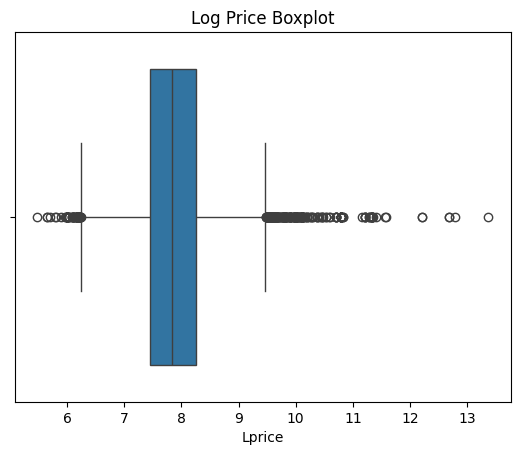

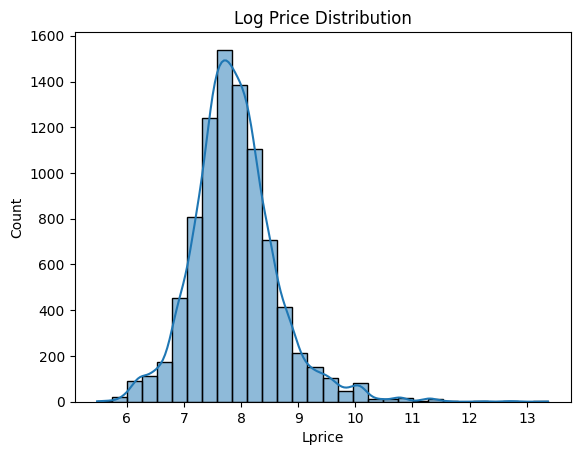

In [37]:
# Boxplot to check for outliers in the 'Lprice' column
sns.boxplot(x=data_prague_price['Lprice'])
plt.title('Log Price Boxplot')
plt.show()

# Histogram to understand the distribution of 'Lprice'
sns.histplot(data_prague_price['Lprice'], bins=30, kde=True)
plt.title('Log Price Distribution')
plt.show()

#### Price on the map

In [38]:
# Create price categories
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, data_prague_price['price'].max()]
labels = ['<500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '>3000']
data_prague_price['price_range'] = pd.cut(data_prague_price['price'], bins=bins, labels=labels, include_lowest=True)
# Assign a discrete color for each price range
color_discrete_map = {label: color for label, color in zip(labels, px.colors.qualitative.Plotly)}

# Create Graph
fig = px.scatter_mapbox(data_prague_price, lat="latitude", lon="longitude",
                        color="price_range",  # Use price range for color
                        color_discrete_map=color_discrete_map,  # Use the color map
                        size_max=15,
                        zoom=10,
                        mapbox_style="open-street-map",
                        title="Airbnb Listings in Prague",
                        category_orders={"price_range": labels})  # Ensure legend order

# Improve layout
fig.update_layout(
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    legend_title_text='Price Range'
)

Our explained variable is the Price variable, expressed in CZK per night. 

We can see that the majority of accommodations exceed the threshold of 2000 CZK per night. 

This is definitely influenced by the popularity of the location and the desire to stay in the desired center.


#### Handling missing values and outliers
we used method of interpolation, which is based on 
estimation of missing values based on surrounding values in the given column. 

The 'linear' method denotes linear interpolation, which creates linear connections 
between two neighboring known points and uses them to estimate the missing value.

<class 'pandas.core.frame.DataFrame'>
Index: 7048 entries, 0 to 9387
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   id                                     7048 non-null   int64         
 1   name                                   7048 non-null   object        
 2   picture_url                            7048 non-null   object        
 3   host_id                                7048 non-null   int64         
 4   host_since                             7048 non-null   datetime64[ns]
 5   host_response_rate                     7048 non-null   float64       
 6   host_acceptance_rate                   7048 non-null   float64       
 7   neighbourhood_cleansed                 7048 non-null   object        
 8   latitude                               7048 non-null   float64       
 9   longitude                              7048 non-null   float64      

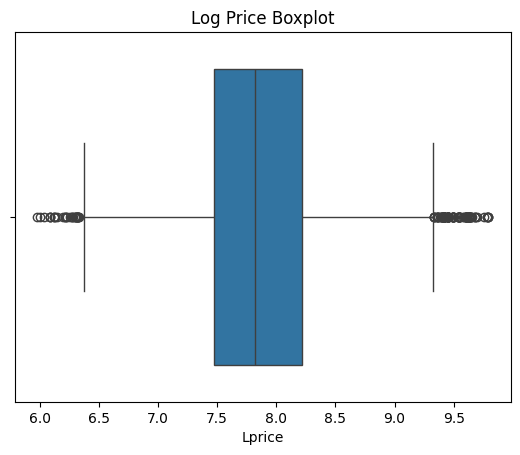

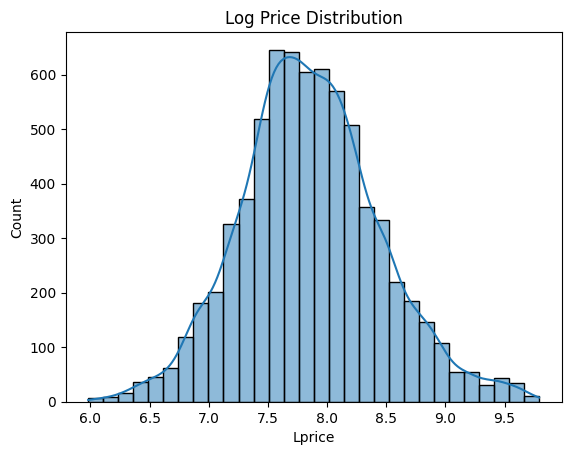

<class 'pandas.core.frame.DataFrame'>
Index: 8708 entries, 0 to 9387
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   id                                     8708 non-null   int64         
 1   name                                   8708 non-null   object        
 2   picture_url                            8708 non-null   object        
 3   host_id                                8708 non-null   int64         
 4   host_since                             8708 non-null   datetime64[ns]
 5   host_response_rate                     8708 non-null   float64       
 6   host_acceptance_rate                   8708 non-null   float64       
 7   neighbourhood_cleansed                 8708 non-null   object        
 8   latitude                               8708 non-null   float64       
 9   longitude                              8708 non-null   float64      

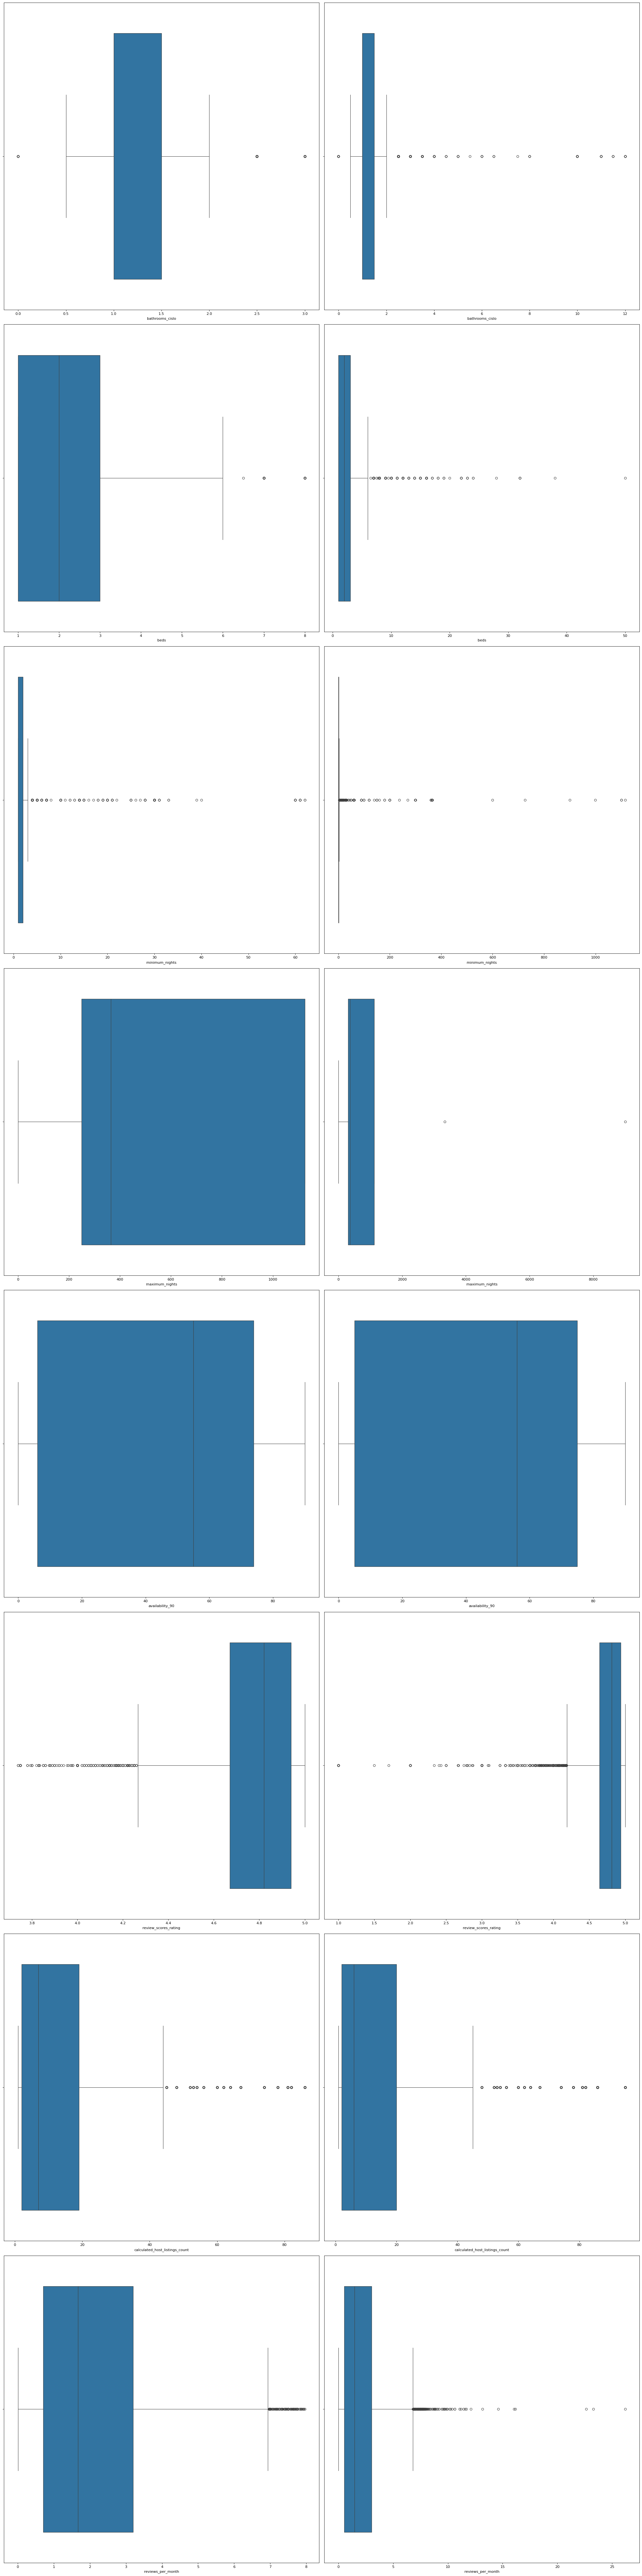

In [39]:
data_prague_price[numeric_columns].isna().sum()
data_prague_price['beds'] = data_prague_price['beds'].interpolate(method='linear')
data_prague_price['review_scores_rating'] = data_prague_price['review_scores_rating'].interpolate(method='linear')
data_prague_price['host_response_rate'] = data_prague_price['host_response_rate'].interpolate(method='linear')
data_prague_price['host_acceptance_rate'] = data_prague_price['host_acceptance_rate'].interpolate(method='linear')
data_prague_price['reviews_per_month'] = data_prague_price['reviews_per_month'].interpolate(method='linear')
data_prague_price['bathrooms_cislo'] = data_prague_price['bathrooms_cislo'].interpolate(method='linear')

# Defining a function to remove outliers based on standard deviation. 
#this code removes all observation that lies furher than 3times there standart deviation from mean. 
def remove_outliers(df, threshold=3):
    df_cleaned = df.copy()  # Creating a copy of the DataFrame
    for column in df_cleaned.select_dtypes(include=['number']):  # Selecting only numeric columns
        mean = df_cleaned[column].mean()
        std_dev = df_cleaned[column].std()
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned

# Calling the function to remove outliers - we created new dataframe which contains 39 variables, each with 7048 observation. 
df_cleaned = remove_outliers(data_prague_price)
df_cleaned.info()

# Boxplot to check for outliers in the 'Lprice' column after. 
sns.boxplot(x=df_cleaned['Lprice'])
plt.title('Log Price Boxplot')
plt.show()

# Histogram to understand the distribution of 'Lprice' - see any changes after outlier puf 
sns.histplot(df_cleaned['Lprice'], bins=30, kde=True)
plt.title('Log Price Distribution')
plt.show()

# Comparison of record counts
data_prague_price.info()
df_cleaned.info()

# Creating subplots
fig, axs = plt.subplots(8, 2, figsize=(25, 100), dpi=80)

# Displaying boxplot of variables after all necesary changes in dataset with and withour outliners. 
sns.boxplot(data=df_cleaned, x="bathrooms_cislo", ax=axs[0, 0])
sns.boxplot(data=data_prague_price, x="bathrooms_cislo", ax=axs[0, 1])

sns.boxplot(data=df_cleaned, x="beds", ax=axs[1, 0])
sns.boxplot(data=data_prague_price, x="beds", ax=axs[1, 1])

sns.boxplot(data=df_cleaned, x="minimum_nights", ax=axs[2, 0])
sns.boxplot(data=data_prague_price, x="minimum_nights", ax=axs[2, 1])

sns.boxplot(data=df_cleaned, x="maximum_nights", ax=axs[3, 0])
sns.boxplot(data=data_prague_price, x="maximum_nights", ax=axs[3, 1])

sns.boxplot(data=df_cleaned, x="availability_90", ax=axs[4, 0])
sns.boxplot(data=data_prague_price, x="availability_90", ax=axs[4, 1])

sns.boxplot(data=df_cleaned, x="review_scores_rating", ax=axs[5, 0])
sns.boxplot(data=data_prague_price, x="review_scores_rating", ax=axs[5, 1])

sns.boxplot(data=df_cleaned, x="calculated_host_listings_count", ax=axs[6, 0])
sns.boxplot(data=data_prague_price, x="calculated_host_listings_count", ax=axs[6, 1])

sns.boxplot(data=df_cleaned, x="reviews_per_month", ax=axs[7, 0])
sns.boxplot(data=data_prague_price, x="reviews_per_month", ax=axs[7, 1])

plt.tight_layout()
plt.show()

In this graph, variables included in the following models were displayed before and after outlier and NA value adjustments. These adjustments notably affected variables such as bathroom_cislo and beds.


In [40]:
#saved data used for further modeling
df_cleaned.dtypes
df_cleaned.to_csv("data_cleaned.csv")